In [1]:
import numpy as np
import pickle
import torch

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS è disponibile!")
else:
    device = torch.device("cpu")
    print("MPS non è disponibile, si utilizza la CPU.")

MPS è disponibile!


In [2]:
def logistic_fun(x, k=1, x0=0):
    return 1.0 / (1.0 + np.exp(-k * (x - x0)))

In [3]:
def add_noise(user_embedding, noise_strength):
    noise = np.random.normal(0, noise_strength, user_embedding.shape)
    return user_embedding + noise

In [4]:
def get_sites_ads_sigmoids(descr_annunci_emb, sites_embeddings):
    # First, compute the scalar product between sites and ads descriptions embeddings
    sites_ad_dot_prod = {}
    for site_name, site_emb in sites_embeddings.items():
        sites_ad_dot_prod[site_name] = {}
        for prod_name, prod_emb in descr_annunci_emb.items():
            sites_ad_dot_prod[site_name][prod_name] = prod_emb @ site_emb
    # Take the mean and standard deviation of the scalar products
    full_array_scores = np.array([list(descr_seg_score.values()) for descr_seg_score in list(sites_ad_dot_prod.values())])
    mean_scores = np.mean(full_array_scores)
    std_scores = np.std(full_array_scores)
    # Compute logistic function for each score
    sigmoids = {}
    for site_name, descr_seg_score in sites_ad_dot_prod.items():
        sigmoids[site_name] = {}
        for seg_name, score in descr_seg_score.items():
            sigmoids[site_name][seg_name] = logistic_fun(score, k=1/(0.5*std_scores), x0=mean_scores)
    return sites_ad_dot_prod, sigmoids

In [3]:
# leggi embeddings
adv_embeddings = pickle.load(open("../src/publisher_embedding/data/embeddings_to_pick/ad_embeddings_red_70.pkl", "rb"))
publisher_embeddings = pickle.load(open("../src/publisher_embedding/data/embeddings_to_pick/sites_embeddings_red_70.pkl", "rb"))

In [4]:
rounds_per_iter = 500
num_iter = 100
dim_embedding = 70
noise_strength = 0.01

In [5]:
n, m, k = num_iter, rounds_per_iter, dim_embedding

In [50]:
pub_tens = torch.tensor(publisher_embeddings['corriere.it']).float().to(device)

In [52]:
new_tensor = pub_tens.repeat(n, m, 1).to(device)

In [55]:
noise_tensor = torch.normal(0, noise_strength, size=(n,m,k)).to(device)

In [56]:
new_tensor = torch.add(new_tensor, noise_tensor).to(device)

In [6]:
def generate_user_contexts(num_iter, rounds_per_iter, dim_embedding, noise_strength, publisher_embeddings):
    """
    Genera un dizionario con publisher come chiave e un tensore con dimensioni num_iter x rounds_per_iter x dim_embedding
    """
    n, m, k = num_iter, rounds_per_iter, dim_embedding
    user_contexts = {}
    for publisher_name, pub_emb in publisher_embeddings.items():
        pub_tens = torch.tensor(pub_emb).float().to(device)
        new_tensor = pub_tens.repeat(n, m, 1).to(device)
        noise_tensor = torch.normal(0, noise_strength, size=(n,m,k)).to(device)
        new_tensor = torch.add(new_tensor, noise_tensor).to(device)
        user_contexts[publisher_name] = new_tensor
    return user_contexts

In [10]:
# Prendo solo i primi 300 publisher
for i in range(250):
    publisher_embeddings.popitem()

In [11]:
user_contexts = generate_user_contexts(num_iter, rounds_per_iter, dim_embedding, noise_strength, publisher_embeddings)

In [ ]:
scalar_products = {}
for publisher_name, user_context in user_contexts.items():
    scalar_products[publisher_name] = {}
    for adv_name, adv_emb in adv_embeddings.items():
        scalar_products[publisher_name][adv_name] = torch.matmul(user_context, torch.tensor(adv_emb).float().to(device)).to(device)

In [38]:
all_tensors = []
for publisher_name, adv_scores in scalar_products.items():
    for adv_name, score in adv_scores.items():
        all_tensors.append(score)
all_tensors = torch.cat(all_tensors).to(device)
mean_scores = torch.mean(all_tensors).to(device)
std_scores = torch.std(all_tensors).to(device)

In [39]:
sigmoids = {}
for publisher_name, adv_scores in scalar_products.items():
    sigmoids[publisher_name] = {}
    for adv_name, score in adv_scores.items():
        sigmoids[publisher_name][adv_name] = torch.special.expit((score-mean_scores) / (0.5*std_scores)).to(device)

In [ ]:
def compute_sigmoids(user_contexts, adv_embeddings):
    """
    Restituisco un dizionario con publisher come chiave e un dizionario con annunci come 
    chiave e una matrice torch con dimensioni num_iter x rounds_per_iter come valore
    """
    # Compute scalar products
    scalar_products = {}
    for publisher_name, user_context in user_contexts.items():
        scalar_products[publisher_name] = {}
        for adv_name, adv_emb in adv_embeddings.items():
            scalar_products[publisher_name][adv_name] = torch.matmul(user_context, torch.tensor(adv_emb).float().to(device)).to(device)
    # Compute mean and std over all scalar products for all publishers and ads
    all_tensors = []
    for publisher_name, adv_scores in scalar_products.items():
        for adv_name, score in adv_scores.items():
            all_tensors.append(score)
    all_tensors = torch.cat(all_tensors).to(device)
    mean_scores = torch.mean(all_tensors).to(device)
    std_scores = torch.std(all_tensors).to(device)
    # Compute sigmoids
    sigmoids = {}
    for publisher_name, adv_scores in scalar_products.items():
        sigmoids[publisher_name] = {}
        for adv_name, score in adv_scores.items():
            sigmoids[publisher_name][adv_name] = torch.special.expit((score-mean_scores) / (0.5*std_scores)).to(device)
    return sigmoids

In [12]:
user_contexts['corriere.it'].shape

torch.Size([100, 500, 70])

In [13]:
ad_esempio = torch.tensor(adv_embeddings['Reflex Pro']).float().to(device)

In [15]:
result = torch.matmul(user_contexts['corriere.it'], ad_esempio).to(device)

In [16]:
# media e std
mean = torch.mean(result).to(device)
std = torch.std(result).to(device)

In [17]:
def logistic_fun(x, k=1.0, x0=0.0):
    return 1.0 / (1.0 + torch.exp(-k * (x - x0)))

In [31]:
sigmoids_esempio = logistic_fun(result, k=1/(0.5*std), x0=mean).to(device)

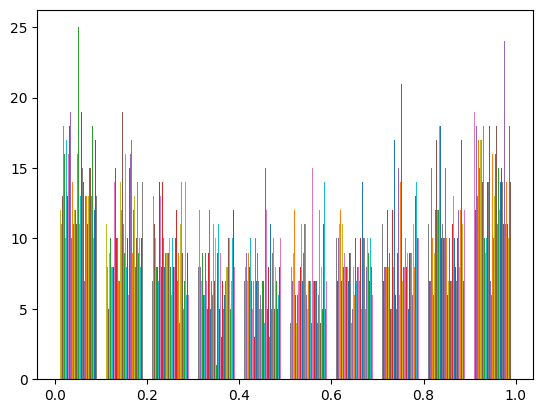

In [32]:
# plot distribuzione
import matplotlib.pyplot as plt
plt.hist(sigmoids_esempio.cpu().detach().numpy())
plt.show()

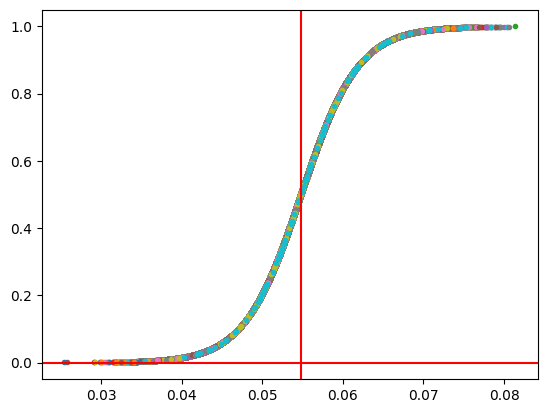

In [34]:
plt.plot(result.cpu().detach().numpy(), sigmoids_esempio.cpu().detach().numpy(), '.')
plt.axvline(x=mean.cpu().detach().numpy(), color='r')
plt.axhline(y=0, color='r')
plt.show()

In [68]:
import numpy as np

def generate_user_contexts(num_iter, rounds_per_iter, dim_embedding, noise_strength, publisher_embeddings):
    """
    Genera un dizionario con publisher come chiave e un array con dimensioni num_iter x rounds_per_iter x dim_embedding
    """
    n, m, k = num_iter, rounds_per_iter, dim_embedding
    user_contexts = {}
    for publisher_name, pub_emb in publisher_embeddings.items():
        new_array = np.tile(pub_emb, (n, m, 1))
        noise_array = np.random.normal(0, noise_strength, size=(n, m, k))
        new_array += noise_array
        user_contexts[publisher_name] = new_array
    return user_contexts

def compute_sigmoids(user_contexts, adv_embeddings):
    """
    Restituisco un dizionario con publisher come chiave e un dizionario con annunci come
    chiave e una matrice numpy con dimensioni num_iter x rounds_per_iter come valore
    """
    # Compute scalar products
    scalar_products = {}
    for publisher_name, user_context in user_contexts.items():
        scalar_products[publisher_name] = {}
        for adv_name, adv_emb in adv_embeddings.items():
            scalar_products[publisher_name][adv_name] = np.einsum('ijk,k->ij', user_context, adv_emb)
    # Compute mean and std over all scalar products for all publishers and ads
    all_tensors = np.concatenate([score for adv_scores in scalar_products.values() for score in adv_scores.values()])
    mean_scores = np.mean(all_tensors)
    std_scores = np.std(all_tensors)
    # Compute sigmoids
    sigmoids = {}
    for publisher_name, adv_scores in scalar_products.items():
        sigmoids[publisher_name] = {}
        for adv_name, score in adv_scores.items():
            sigmoids[publisher_name][adv_name] = 1 / (1 + np.exp(-(score - mean_scores) / (0.5*std_scores)))
    return sigmoids

def initialize_deal(num_iter, rounds_per_iter, dim_embedding, noise_strength, publisher_embeddings, adv_embeddings):
    user_contexts = generate_user_contexts(num_iter, rounds_per_iter, dim_embedding, noise_strength, publisher_embeddings)
    adv_sigmoids = compute_sigmoids(user_contexts, adv_embeddings)
    return user_contexts, adv_sigmoids

In [69]:
user_contexts, adv_sigmoids = initialize_deal(num_iter, rounds_per_iter, dim_embedding, noise_strength, publisher_embeddings, adv_embeddings)

In [70]:
np_sig = np.array([list(ad.values()) for ad in adv_sigmoids.values()]).flatten()

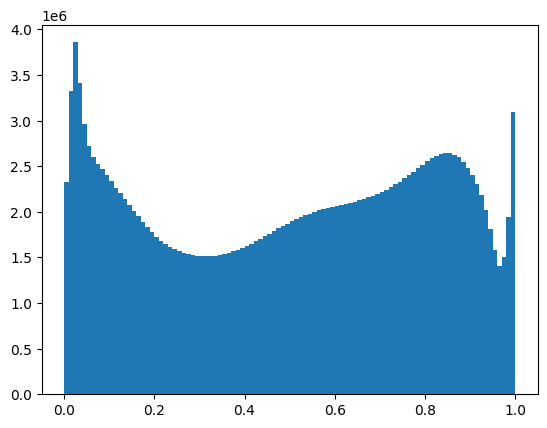

In [71]:
plt.hist(np_sig, bins=100)
plt.show()

In [73]:
cor = adv_sigmoids['corriere.it']['Reflex Pro']
mean = np.mean(cor)
std = np.std(cor)